In [22]:
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)         # pokazuj wszystkie kolumny
# pd.set_option("display.width", 2000)               # większa "szerokość" wydruku
# pd.set_option("display.max_colwidth", 80)          # limit szerokości komórki (ustaw np. None, jeśli chcesz bez limitu)
pd.set_option("display.expand_frame_repr", False)  # nie łam DataFrame na kilka "bloków" w pionie

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

DATA_DIR = Path("data")  # folder z CSV
CSV_GLOB = "*.csv"

SNAPSHOT_RE = re.compile(r"(?P<year>20\d{2})[_-](?P<month>\d{2})")

In [23]:
paths = sorted(DATA_DIR.glob(CSV_GLOB))
if not paths:
    raise FileNotFoundError(f"Brak plików CSV w: {DATA_DIR.resolve()}")

[p.name for p in paths[:10]], len(paths)

(['apartments_pl_2023_08.csv',
  'apartments_pl_2023_09.csv',
  'apartments_pl_2023_10.csv',
  'apartments_pl_2023_11.csv',
  'apartments_pl_2023_12.csv',
  'apartments_pl_2024_01.csv',
  'apartments_pl_2024_02.csv',
  'apartments_pl_2024_03.csv',
  'apartments_pl_2024_04.csv',
  'apartments_pl_2024_05.csv'],
 19)

In [24]:
dfs = []

for p in paths:
    df = pd.read_csv(p)

    # snapshot_date z nazwy pliku: YYYY_MM lub YYYY-MM -> YYYY-MM-01
    m = SNAPSHOT_RE.search(p.name)
    snapshot_date = pd.NaT
    if m:
        snapshot_date = pd.Timestamp(year=int(m.group("year")), month=int(m.group("month")), day=1)

    df["source_file"] = p.name
    df["snapshot_date"] = snapshot_date
    df["snapshot_year"] = pd.to_datetime(df["snapshot_date"]).dt.year
    df["snapshot_month"] = pd.to_datetime(df["snapshot_date"]).dt.month

    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all['price_per_m2'] = df_all['price'] / df_all['squareMeters']
df_all.shape

display(df_all[['city', 'price', 'squareMeters', 'price_per_m2']].head())

,city,price,squareMeters,price_per_m2
0,szczecin,415000,63.00,6587.301587
1,szczecin,395995,36.00,10999.861111
2,szczecin,565000,73.02,7737.606135
3,szczecin,640000,87.60,7305.936073
4,szczecin,759000,66.00,11500.000000


In [25]:
# Rozpoznanie po nazwie pliku (source_file)
# rent -> ma "rent" w nazwie
mask_rent = df_all["source_file"].str.lower().str.contains("rent", na=False)

# sell/ceny -> wszystko co NIE jest rent
mask_sell = ~mask_rent

df_rent = df_all[mask_rent].copy()
df_sell = df_all[mask_sell].copy()

df_rent.shape, df_sell.shape

((70847, 33), (195568, 33))

In [26]:
df_other = df_all[~(mask_rent | mask_sell)].copy()
df_other["source_file"].value_counts().head(20), df_other.shape

(Series([], Name: count, dtype: int64), (0, 33))

In [27]:
print("df_rent (3 pierwsze wiersze):")
display(df_rent.head(3))

print("\ndf_sell (3 pierwsze wiersze):")
display(df_sell.head(3))

df_rent (3 pierwsze wiersze):


,id,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,schoolDistance,clinicDistance,postOfficeDistance,kindergartenDistance,restaurantDistance,collegeDistance,pharmacyDistance,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price,source_file,snapshot_date,snapshot_year,snapshot_month,price_per_m2
195568,2a1a6db97ff122d6bc148abb6f0e498a,szczecin,blockOfFlats,52.0,2.0,3.0,3.0,2008.0,53.460535,14.545416,4.26,2.0,0.753,1.049,0.595,0.674,0.229,2.200,0.307,condominium,brick,NaN,yes,yes,no,no,no,3500,apartments_rent_pl_2023_11.csv,2023-11-01,2023,11,67.307692
195569,5a0cb42c088eadf75aa98a4118640048,szczecin,blockOfFlats,57.0,3.0,NaN,10.0,1976.0,53.440955,14.566024,1.98,14.0,0.126,0.875,0.586,0.058,0.129,1.323,0.189,condominium,NaN,premium,no,yes,yes,no,no,3000,apartments_rent_pl_2023_11.csv,2023-11-01,2023,11,52.631579
195570,996722490efcb4b34d48bb84a9a72838,szczecin,NaN,43.4,2.0,3.0,4.0,NaN,53.435746,14.560764,1.37,17.0,0.265,0.373,0.385,0.364,0.116,0.714,0.211,condominium,NaN,NaN,no,yes,no,no,no,1900,apartments_rent_pl_2023_11.csv,2023-11-01,2023,11,43.778802



df_sell (3 pierwsze wiersze):


,id,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,schoolDistance,clinicDistance,postOfficeDistance,kindergartenDistance,restaurantDistance,collegeDistance,pharmacyDistance,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price,source_file,snapshot_date,snapshot_year,snapshot_month,price_per_m2
0,f8524536d4b09a0c8ccc0197ec9d7bde,szczecin,blockOfFlats,63.00,3.0,4.0,10.0,1980.0,53.378933,14.625296,6.53,9.0,0.118,1.389,0.628,0.105,1.652,NaN,0.413,condominium,concreteSlab,NaN,yes,yes,yes,no,yes,415000,apartments_pl_2023_08.csv,2023-08-01,2023,8,6587.301587
1,accbe77d4b360fea9735f138a50608dd,szczecin,blockOfFlats,36.00,2.0,8.0,10.0,NaN,53.442692,14.559690,2.15,16.0,0.273,0.492,0.652,0.291,0.348,1.404,0.205,cooperative,concreteSlab,NaN,no,yes,yes,no,yes,395995,apartments_pl_2023_08.csv,2023-08-01,2023,8,10999.861111
2,8373aa373dbc3fe7ca3b7434166b8766,szczecin,tenement,73.02,3.0,2.0,3.0,NaN,53.452222,14.553333,3.24,9.0,0.275,0.672,0.367,0.246,0.300,1.857,0.280,condominium,brick,NaN,no,no,no,no,no,565000,apartments_pl_2023_08.csv,2023-08-01,2023,8,7737.606135


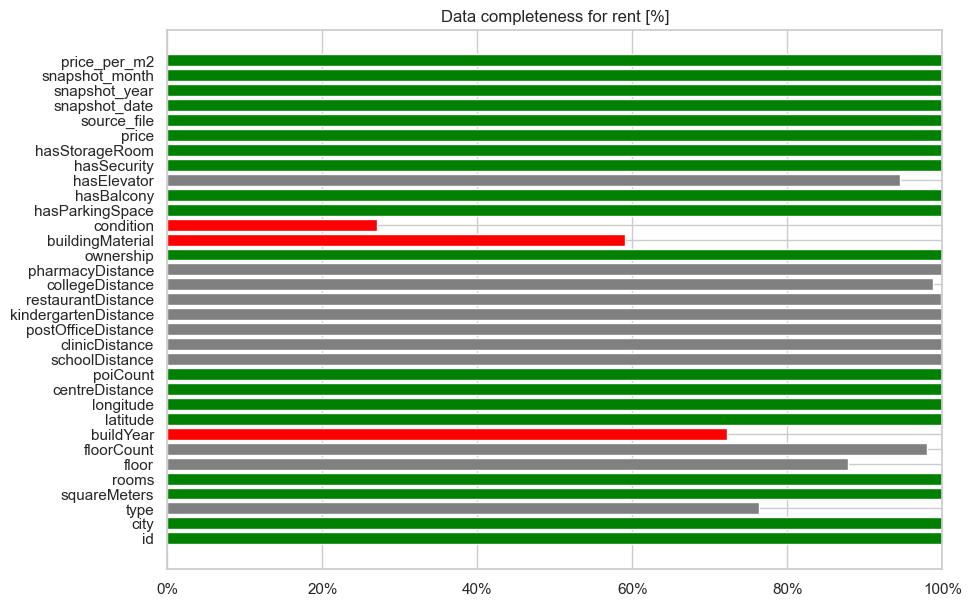

In [28]:
rentCols = df_rent.columns
nonEmpty = []
barColors = []
for colName in rentCols:
  completeness = 1-len(df_rent[df_rent[colName].isnull()])/len(df_rent)
  nonEmpty.append(completeness)
  if(completeness == 1):
     barColors.append('green')
  elif completeness < 0.75:
    barColors.append('red')
  else:
     barColors.append('grey')

def percent_formatter(x, pos):
    return str(round(x*100)) + "%"

fig, axs = plt.subplots(figsize=(10, 7))
axs.set_title("Data completeness for rent [%]")
axs.barh(rentCols, nonEmpty, color=barColors)
axs.set_xlim(0, 1)
axs.xaxis.set_major_formatter(percent_formatter)
plt.show()

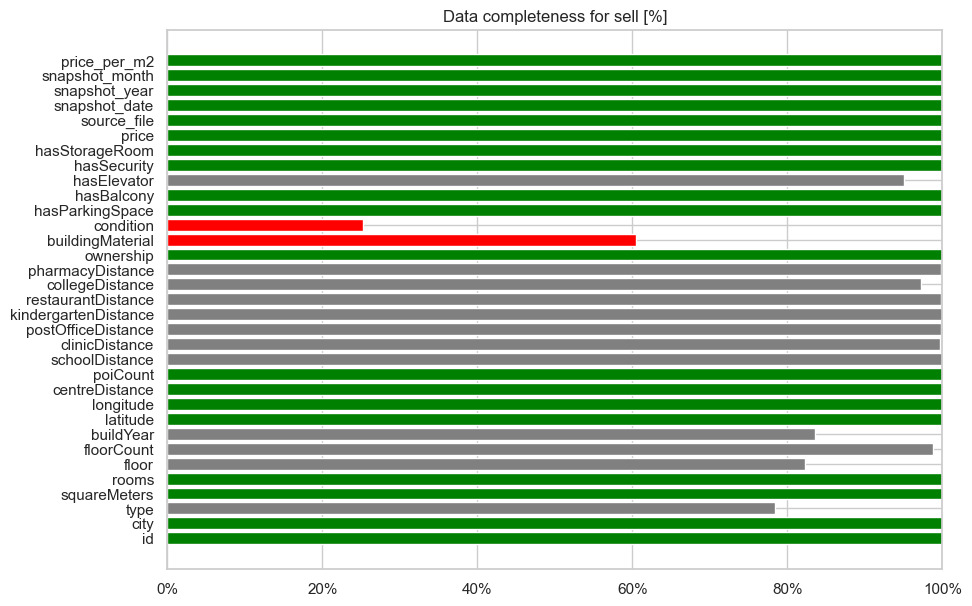

In [29]:
sellCols = df_sell.columns
nonEmpty = []
barColors = []
for colName in sellCols:
  completeness = 1-len(df_sell[df_sell[colName].isnull()])/len(df_sell)
  nonEmpty.append(completeness)
  if(completeness == 1):
     barColors.append('green')
  elif completeness < 0.75:
    barColors.append('red')
  else:
     barColors.append('grey')

def percent_formatter(x, pos):
    return str(round(x*100)) + "%"

fig, axs = plt.subplots(figsize=(10, 7))
axs.set_title("Data completeness for sell [%]")
axs.barh(sellCols, nonEmpty, color=barColors)
axs.set_xlim(0, 1)
axs.xaxis.set_major_formatter(percent_formatter)
plt.show()

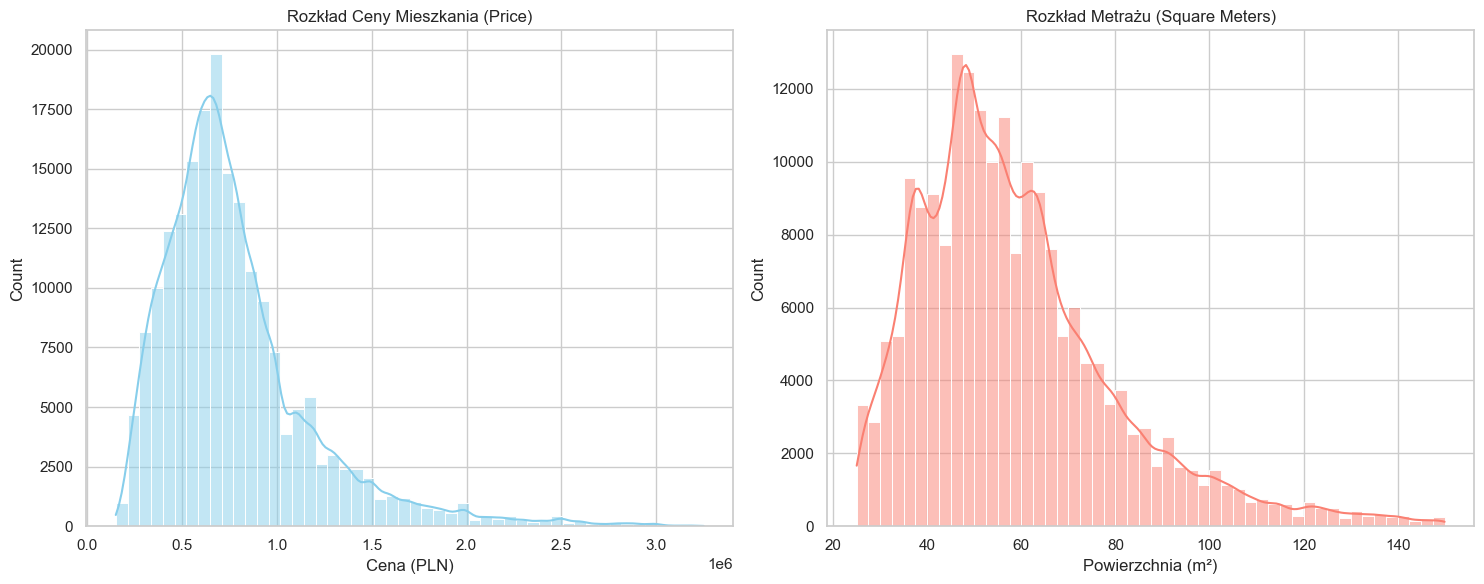

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Rozkład Ceny
sns.histplot(df_sell['price'], bins=50, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Rozkład Ceny Mieszkania (Price)')
axes[0].set_xlabel('Cena (PLN)')

# Rozkład Metrażu
sns.histplot(df_sell['squareMeters'], bins=50, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Rozkład Metrażu (Square Meters)')
axes[1].set_xlabel('Powierzchnia (m²)')

plt.tight_layout()
plt.show()

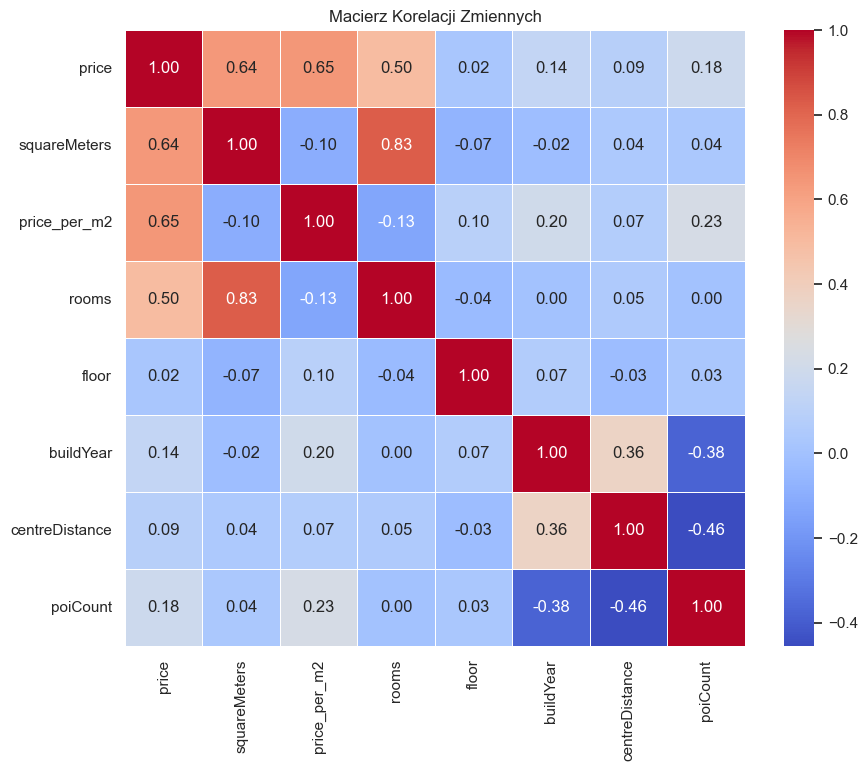

In [33]:
# Wybieramy tylko kolumny numeryczne do korelacji
numeric_cols = ['price', 'squareMeters', 'price_per_m2', 'rooms', 
                'floor', 'buildYear', 'centreDistance', 'poiCount']

corr_matrix = df_sell[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Macierz Korelacji Zmiennych')
plt.show()

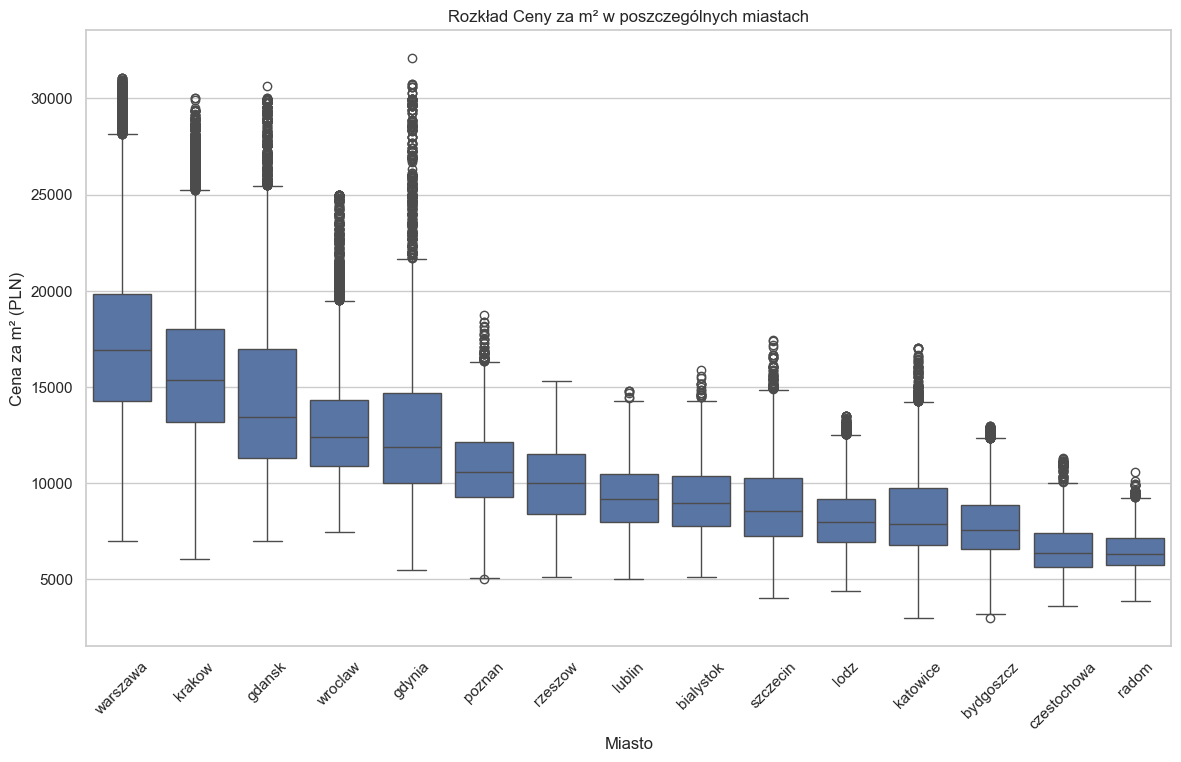

In [ ]:
plt.figure(figsize=(14, 8))

# Sortowanie miast wg mediany ceny za m2
order_cities = df_sell.groupby('city')['price_per_m2'].median().sort_values(ascending=False).index

sns.boxplot(x='city', y='price_per_m2', data=df_sell, order=order_cities, palette="viridis")
plt.title('Rozkład Ceny za m² w poszczególnych miastach')
plt.xlabel('Miasto')
plt.ylabel('Cena za m² (PLN)')
plt.xticks(rotation=45)
plt.show()

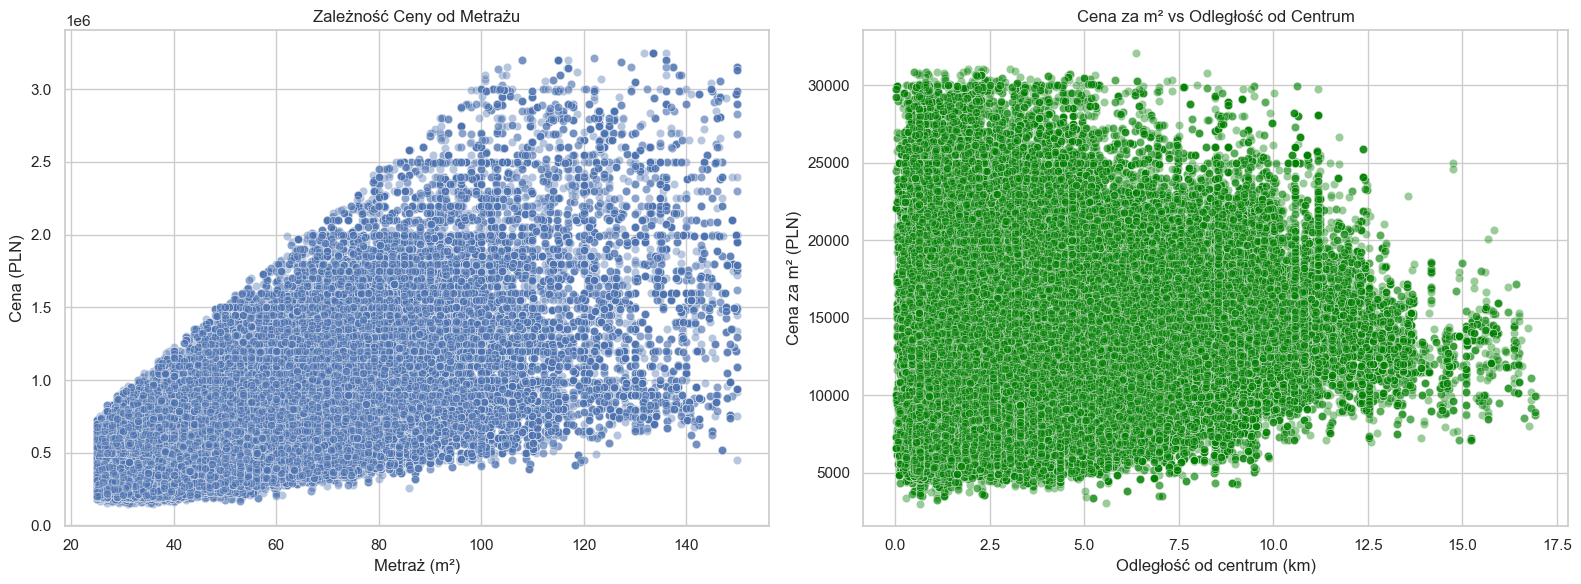

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Cena vs Metraż
sns.scatterplot(x='squareMeters', y='price', data=df_sell, alpha=0.4, ax=axes[0])
axes[0].set_title('Zależność Ceny od Metrażu')
axes[0].set_xlabel('Metraż (m²)')
axes[0].set_ylabel('Cena (PLN)')

# Cena za m2 vs Odległość od centrum
sns.scatterplot(x='centreDistance', y='price_per_m2', data=df_sell, alpha=0.4, color='green', ax=axes[1])
axes[1].set_title('Cena za m² vs Odległość od Centrum')
axes[1].set_xlabel('Odległość od centrum (km)')
axes[1].set_ylabel('Cena za m² (PLN)')

plt.tight_layout()
plt.show()